In [105]:
from typing import Tuple, List, Union
import os
import numpy as np
import matplotlib.pyplot as plt

plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

In [106]:
## Helper functions
def std_deviation(x_arr) -> float:
    """
    Calculates the standard deviation of a given array of numbers.

    Parameters:
    ----------
    x_arr : ndarray
        Array of floats

    Returns:
    -------
    std_dev : float
        The standard deviation of the input array.
    """
    mean = np.mean(x_arr)
    std_dev = 0
    for val in x_arr:
        std_dev += np.power(val - mean, 2)
    return np.sqrt(1.0/(len(x_arr) - 1) * std_dev)


In [107]:
def fixed_pricing_revenue(ticket_fraction: int, nr_costumers: int, nr_trials: int) -> Tuple[List[Union[int,float]],List[Union[int,float]], List[Union[int,float]]]:
    if nr_costumers <= 10:
        raise ValueError("Should have n > 10")
    avg_revenues, std_deviations, n_customers = [], [], []
    for _n in tqdm(range(10,nr_costumers+1)):
        nr_tickets = _n//ticket_fraction
        fixed_price = 1-nr_tickets/_n
        revenues = []
        # Repeating selling to "_n" customers multiple times
        for trial in range(nr_trials):
            ticket_nr = 1
            revenue = 0.0
            # Selling "nr_tickets" to "_n" customers
            for costumer_nr in range(1,_n+1):
                # If any tickets left - try selling
                if ticket_nr <= nr_tickets:
                    v_i = np.random.uniform(low=0.0,high=1)
                    if v_i >= fixed_price:
                        revenue += fixed_price
                        ticket_nr += 1
                # If no tickets left - move to next simulation
                else:
                    break
            revenues.append(revenue)
        n_customers.append(_n)
        avg_revenues.append(np.mean(revenues))
        std_deviations.append(std_deviation(revenues))

    return avg_revenues, std_deviations, n_customers

def variable_pricing_revenue(ticket_fraction: int, nr_costumers: int, nr_trials: int) -> Tuple[List[Union[int,float]], List[Union[int,float]], List[Union[int,float]]]:

    if nr_costumers <= 10:
        raise ValueError("Should have n > 10")

    def p_kn(n,k,exps):
        return (1-exps[n-1,k-1]+exps[n-1,k])/2
    def e_kn(n,k,exps):
        return (1-p_kn(n,k,exps))*(p_kn(n,k,exps)+exps[n-1,k-1])+p_kn(n,k,exps)*exps[n-1,k]

    # Formatted as (n,k): value
    P = np.zeros(shape=(nr_costumers+1,nr_costumers//ticket_fraction+1),dtype=float)
    E = np.zeros(shape=(nr_costumers+1,nr_costumers//ticket_fraction+1),dtype=float)

    for _n in range(0,nr_costumers+1):
        for _k in range(0,nr_costumers//ticket_fraction+1):
            if _k == 0 or _n == 0:
                E[_n,_k] = 0
            else:
                P[_n, _k] = p_kn(_n,_k,E)
                E[_n, _k] = e_kn(_n,_k,E)
    P = np.flip(P[1:,1:])

    avg_revenues, std_deviations, n_customers = [], [], []
    for _n in range(10,nr_costumers+1):
        nr_tickets = _n//ticket_fraction
        revenues = []
        # Repeating selling to "_n" customers multiple times
        for trial in range(nr_trials):
            ticket_nr = 1
            revenue = 0.0
            # Selling "nr_tickets" to "_n" customers
            for costumer_nr in range(1,_n+1):
                # If any tickets left - try selling
                if ticket_nr <= nr_tickets:
                    v_i = np.random.uniform(low=0.0,high=1)
                    if v_i >= P[costumer_nr-1,ticket_nr-1]:
                        revenue += P[costumer_nr-1,ticket_nr-1]
                        ticket_nr += 1
                # If no tickets left - move to next simulation
                else:
                    break
            revenues.append(revenue)
        n_customers.append(_n)
        avg_revenues.append(np.mean(revenues))
        std_deviations.append(std_deviation(revenues))

    return avg_revenues, std_deviations, n_customers



100%|██████████| 91/91 [00:00<00:00, 232.49it/s]


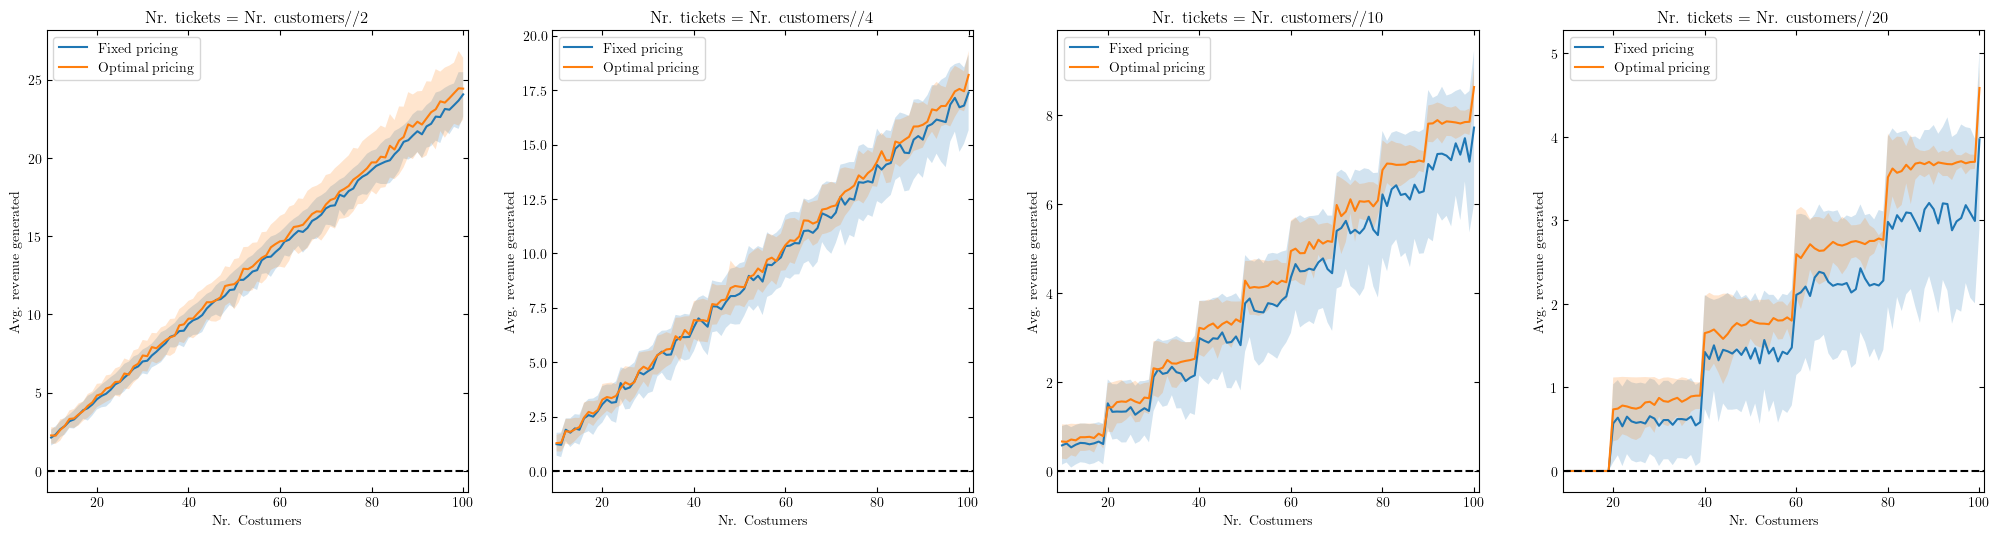

In [108]:
from tqdm import tqdm
fig, ax = plt.subplots(1,4,figsize=(25,6))

revs = []
for idx, factor in enumerate([2,4,10,20]):
    div_fav = factor
    N_trials    = 100
    N_costumers = 100
    avg_standard_revenues, standard_std_deviations, n_customers = fixed_pricing_revenue(ticket_fraction=div_fav,nr_costumers=N_costumers,nr_trials=N_trials)
    avg_optimal_revenues, optimal_std_deviations, _ = variable_pricing_revenue(ticket_fraction=div_fav,nr_costumers=N_costumers,nr_trials=N_trials)
    revs.append((avg_standard_revenues,avg_optimal_revenues))
    ax[idx].set_title(f"Nr. tickets = Nr. customers//{div_fav}")
    ax[idx].plot(n_customers,avg_standard_revenues, label="Fixed pricing")
    ax[idx].fill_between(n_customers, np.array(avg_standard_revenues)-np.array(standard_std_deviations),
                                 np.array(avg_standard_revenues)+np.array(standard_std_deviations), alpha=0.2)

    ax[idx].plot(n_customers,avg_optimal_revenues, label="Optimal pricing")
    ax[idx].fill_between(n_customers, np.array(avg_optimal_revenues)-np.array(optimal_std_deviations),
                                 np.array(avg_optimal_revenues)+np.array(optimal_std_deviations), alpha=0.2)
    ax[idx].set_xlim(0.9*min(n_customers),1.01*max(n_customers))
    ax[idx].hlines(0,0.9*min(n_customers),1.01*max(n_customers),color='k',ls='--')
    ax[idx].legend(loc='upper left')
    ax[idx].set_xlabel("Nr. Costumers")
    ax[idx].set_ylabel("Avg. revenue generated")
plt.savefig("test.pdf")
plt.show()

In [109]:
DATA_PATH = "../Data/Exercise_1/"
filenames = os.listdir(DATA_PATH)
results = {}
for filename in filenames:
    if filename != '.DS_Store':
        data = np.loadtxt(fname=DATA_PATH+filename, dtype=float, encoding='iso-8859-1')
        if len(filename) == 33:
            results[int(filename[-6:-4])] = {}
            results[int(filename[-6:-4])]['Nr. customers'] = data[:,0]
            results[int(filename[-6:-4])]['Standard avg. revenue'] = data[:,1]
            results[int(filename[-6:-4])]['Standard std. deviation'] = data[:,2]
            results[int(filename[-6:-4])]['Optimal avg. revenue'] = data[:,3]
            results[int(filename[-6:-4])]['Optimal std. deviation'] = data[:,4]
        else:
            results[int(filename[-5:-4])] = {}
            results[int(filename[-5:-4])]['Nr. customers'] = data[:,0]
            results[int(filename[-5:-4])]['Standard avg. revenue'] = data[:,1]
            results[int(filename[-5:-4])]['Standard std. deviation'] = data[:,2]
            results[int(filename[-5:-4])]['Optimal avg. revenue'] = data[:,3]
            results[int(filename[-5:-4])]['Optimal std. deviation'] = data[:,4]

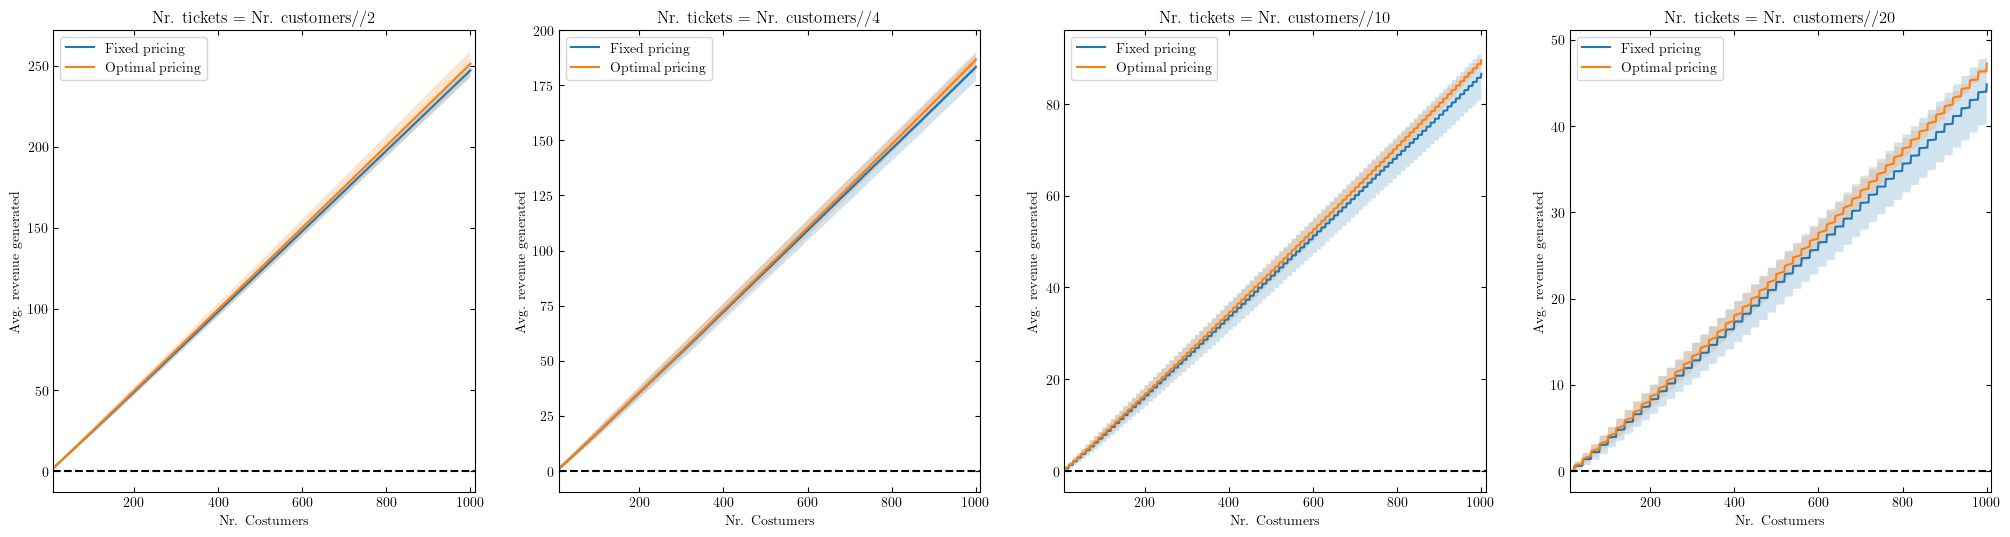

In [110]:
fig, ax = plt.subplots(1,4,figsize=(25,6))

for idx, fraction in enumerate(np.sort(list(results.keys()))):
    div_fav     = fraction
    avg_standard_revenues, standard_std_deviations, n_customers = results[fraction]['Standard avg. revenue'], results[fraction]['Standard std. deviation'], results[fraction]['Nr. customers']
    avg_optimal_revenues, optimal_std_deviations = results[fraction]['Optimal avg. revenue'], results[fraction]['Optimal std. deviation']
    revs.append((avg_standard_revenues,avg_optimal_revenues))
    ax[idx].set_title(f"Nr. tickets = Nr. customers//{div_fav}")
    ax[idx].plot(n_customers,avg_standard_revenues, label="Fixed pricing")
    ax[idx].fill_between(n_customers, np.array(avg_standard_revenues)-np.array(standard_std_deviations),
                                 np.array(avg_standard_revenues)+np.array(standard_std_deviations), alpha=0.2)

    ax[idx].plot(n_customers,avg_optimal_revenues, label="Optimal pricing")
    ax[idx].fill_between(n_customers, np.array(avg_optimal_revenues)-np.array(optimal_std_deviations),
                                 np.array(avg_optimal_revenues)+np.array(optimal_std_deviations), alpha=0.2)
    ax[idx].set_xlim(0.9*min(n_customers),1.01*max(n_customers))
    ax[idx].hlines(0,0.9*min(n_customers),1.01*max(n_customers),color='k',ls='--')
    ax[idx].legend(loc='upper left')
    ax[idx].set_xlabel("Nr. Costumers")
    ax[idx].set_ylabel("Avg. revenue generated")
plt.savefig("test_2.pdf")
plt.show()